In [1]:
import numpy as np
import epsnoise
import treecorr
import matplotlib.pyplot as plt

np.random.seed(47350)

In [2]:
# ------------------
# PSF functions
# ------------------

def get_covmat(e1,e2,galhlr):
    """
    Returns the covariance matrix of the lensing shears given the two components
    [assuming N galaxies in the blended system]
    e1 : the array of the first component of the shape for N galaxies, epsilon ellipticity
    e2 : the array of the second component of the shape for N galaxies, epsilon ellipticity
    """
    e = np.sqrt(e1**2+e2**2)
    if np.isscalar(e):
        if not np.isfinite(e):
            print(f'Warning: |e| is not finite.\n|e|={e}\ne1={e1}\ne2={e2}')
    else:
        if any(not np.isfinite(e_abs) for e_abs in e):
            einf = ~np.isfinite(e)
            print(f'Warning: |e| is not finite.\n|e|={e[einf]}\ne1={e1[einf]}\ne2={e2[einf]}')

    if np.isscalar(e):
        if e>=1:
            print(f'Warning: |e|>=1 which will lead to negative value under sqrt.\n|e|={e}\ne1={e1}\ne2={e2}')
    else:
        if any(e_abs>=1 for e_abs in e):
            ege1 = e>=1
            print(f'Warning: |e|>=1 which will lead to negative value under sqrt.\n|e|={e[ege1]}\ne1={e1[ege1]}\ne2={e2[ege1]}')

    sigma_round = galhlr/3600/np.sqrt(2.*np.log(2)) # degrees # galhlr = FLUX_RADIUS in arcsec

    # a and b are deviations from a circle of radius r=sigma_round
    a = sigma_round * np.sqrt((1+e)/(1-e)) # wrong: a = sigma_round /(1-gamma)
    b = sigma_round * np.sqrt((1-e)/(1+e)) # wrong: b = sigma_round /(1+gamma)

    theta = 0.5*np.arctan2(e2,e1) # radians
    
    if np.isscalar(theta):
        R = np.array([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])
        Sigma_0 = np.array([[a**2,0],[0,b**2]])
        Sigma   = np.dot(R,np.dot(Sigma_0,R.T))
    else:
        N = theta.size
        R = [np.array([[np.cos(theta[k]),-np.sin(theta[k])],[np.sin(theta[k]),np.cos(theta[k])]]) for k in range(N)]
        Sigma_0 = [np.array([[a[k]**2,0],[0,b[k]**2]]) for k in range(N)]
        Sigma   = [np.dot(R[k],np.dot(Sigma_0[k],R[k].T)) for k in range(N)]
    return np.array(Sigma)

def Qij(i,j,A,mu,c,Sigma,individual=False,axis=None): #slow?
    """
    Returns second moments assuming extended gaussian profiles
    [assuming N galaxies in the blended system]
    A     :: the array of total NORMALIZED fluxes
    mu    :: the array (N vectors) of galaxy centers (i.e. the peaks of the Gaussians)
    c     :: the vector pointing to the luminosity center of the blended system
    Sigma :: the array of N covariance matrices (2 by 2)
    individual :: True if we are interested in second moments of individual galaxies (non-blends), False sums over everything (good for blending)
    """

    delta = np.radians(c[1]) # central declination in radians
    cosd = np.cos(delta)
    cf = cosd if i!=j else cosd**2 if i==j==1 else 1.0   
    i,j = i-1, j-1

    if individual:
        Qij = Sigma.T[i][j]+(mu[i]-c[i])*(mu[j]-c[j])*cf
    else: # sum over galaxies in a blend
        Qij = np.sum( A*(Sigma.T[:][i][j]+(mu[i]-c[i])*(mu[j]-c[j])*cf), axis=axis )
        Qij = Qij/np.sum(A, axis=axis)

    return Qij


def convolve_with_PSF(shape1,shape2,galhlr,PSF_FWHM=0):
    if np.isscalar(galhlr):
        if galhlr<=0: raise ValueError("galhlr can't be negative!")
    else:
        if any(gh<=0 for gh in galhlr): raise ValueError("galhlr can't be negative!")
    PSF_size = PSF_FWHM/2 # only true for Gaussians
    Sigma = get_covmat(shape1,shape2,galhlr)
    Sigma_PSF = get_covmat(0,0,PSF_size) # 0, 0 for circular
    # N = A.size
    mu, c = np.array([0,0]), np.array([0,0])
    A_gal = 1 # it does not affect my Qij calculation since I will normalize and IT IS ONLY ONE OBJECT! we do not have different weights through A
    Q11 = Qij(1,1,A_gal,mu,c,Sigma,individual=True) # A_gal is irrelevant here
    Q22 = Qij(2,2,A_gal,mu,c,Sigma,individual=True)
    Q12 = Qij(1,2,A_gal,mu,c,Sigma,individual=True)
    A_psf = 1 # apparently it does not affect my Qij calculation since I will normalize and IT IS ONLY ONE OBJECT! we do not have different weights through A
    P11 = Qij(1,1,A_psf,mu,c,Sigma_PSF,individual=True) 
    P22 = Qij(2,2,A_psf,mu,c,Sigma_PSF,individual=True)
    P12 = Qij(1,2,A_psf,mu,c,Sigma_PSF,individual=True) # 0 circular!
    Q11 += P11        
    Q22 += P22        
    Q12 += P12       
    # epsilon-ellipticity, not chi-ellipticity!
    e1_sys = (Q11-Q22)/(Q11+Q22+2*(Q11*Q22-Q12**2)**0.5)
    e2_sys = 2.0*Q12/(Q11+Q22+2*(Q11*Q22-Q12**2)**0.5)
    galhlr_sys = 3600*(Q11*Q22-Q12**2)**0.25 * np.sqrt(2.*np.log(2)) # in arcsec 
    return e1_sys, e2_sys, galhlr_sys

In [3]:
class TestObservedEllipticity:
    def __init__(self, ngal):
        self.ngal = ngal
    
    def make_shear_field(self):
        gamma0 = 0.05
        r0 = 60. #10
        #ngal = 1000000
        L = 50.*r0
        rng = np.random.RandomState(2643021)
        self.x = (rng.random_sample(self.ngal)-0.5) * L
        self.y = (rng.random_sample(self.ngal)-0.5) * L
        r2 = (self.x**2 + self.y**2)/r0**2
        gamma1 = -gamma0 * np.exp(-r2/2.) * (self.x**2-self.y**2)/r0**2
        gamma2 = +(-gamma0 * np.exp(-r2/2.) * (2.*self.x*self.y)/r0**2)
        self.gamma = gamma1 + 1j*gamma2

    def sample_eps(self, sigma_e=0.1):
        self.e = epsnoise.sampleEllipticity(self.ngal, sigma_e) # intrinsic
    
    def add_shear(self):
        self.e = epsnoise.addShear(self.e, self.gamma) # lensed

    def add_psf(self, psf_fwhm=None, gal_hlr=None):
        e1, e2, _ = convolve_with_PSF(np.real(self.e),np.imag(self.e),gal_hlr,PSF_FWHM=psf_fwhm)
        self.e = e1 + 1j*e2

    def add_noise(self, nu=None):
        self.e = epsnoise.addNoise(self.e, nu, transform_eps=True)

    def find_e_components(self):
        self.e1 = np.real(self.e)
        self.e2 = np.imag(self.e)

    def make_corrobj(self, bin_size=None):
        self.cat = treecorr.Catalog(x=self.x, y=self.y, g1=self.e1, g2=self.e2, x_units='arcmin', y_units='arcmin', flip_g1=True, flip_g2=False)
        self.gg = treecorr.GGCorrelation(bin_size=bin_size, min_sep=10., max_sep=100., sep_units='arcmin', verbose=1)

    def calc_gg(self):
        self.gg.process(self.cat)

    def plot(self, title, plot_type='scatter'):
        th, xip = self.gg.meanlogr, self.gg.xip
        getattr(plt, plot_type)(th, xip, label = title)
        plt.xlabel(r'$ln(\theta)$', size=18)
        plt.ylabel(r'$\xi_{+}$', size=18)
        plt.legend(loc='upper right')
        plt.title(title);
        
    def process_truth(self, bin_size=0.1):
        self.make_shear_field()
        self.sample_eps(sigma_e=0)
        self.add_shear()
        # self.add_noise(nu=35)
        self.find_e_components()
        self.make_corrobj(bin_size=bin_size)
        self.calc_gg()
        self.plot(r'True Shear', plot_type='plot')
        
    def process_with_psf_shear_first(self, sigma_e=0.1, psf_fwhm=0.8, gal_hlr=0.5, nu=35, bin_size=0.1):
        self.make_shear_field()
        self.sample_eps(sigma_e=sigma_e)
        self.add_shear()
        self.add_psf(psf_fwhm=psf_fwhm, gal_hlr=gal_hlr) # arcsec
        self.add_noise(nu=nu)
        self.find_e_components()
        self.make_corrobj(bin_size=bin_size)
        self.calc_gg()
        self.plot(r'Lensed + Convolved')
    
    def process_with_psf_shear_last(self, sigma_e=0.1, psf_fwhm=0.8, gal_hlr=0.5, nu=35, bin_size=0.1):
        self.make_shear_field()
        self.sample_eps(sigma_e=sigma_e)
        self.add_psf(psf_fwhm=psf_fwhm, gal_hlr=gal_hlr) # arcsec
        self.add_shear()
        self.add_noise(nu=nu)
        self.find_e_components()
        self.make_corrobj(bin_size=bin_size)
        self.calc_gg()
        self.plot(r'Convolved + Lensed')
        
    def process_without_psf(self, sigma_e=0.1, nu=35, bin_size=0.1):
        self.make_shear_field()
        self.sample_eps(sigma_e=sigma_e)
        self.add_shear()
        # self.add_psf(fwhm)
        self.add_noise(nu=nu)
        self.find_e_components()
        self.make_corrobj(bin_size=bin_size)
        self.calc_gg()
        self.plot(r'No PSF added')

In [5]:
def plot_comparison(ngal, figsize=(8, 6), sigma_e=0.1, psf_fwhm=0.8, gal_hlr=0.5, nu=35, bin_size=0.1):
    fig = plt.figure(figsize=figsize, tight_layout=True)
    toe = TestObservedEllipticity(ngal)
    toe.process_truth(bin_size=bin_size)
    toe.process_without_psf(sigma_e=sigma_e, nu=nu, bin_size=bin_size)
    toe.process_with_psf_shear_first(sigma_e=sigma_e, psf_fwhm=psf_fwhm, gal_hlr=gal_hlr, nu=nu, bin_size=bin_size)
    toe.process_with_psf_shear_last(sigma_e=sigma_e, psf_fwhm=psf_fwhm, gal_hlr=gal_hlr, nu=nu, bin_size=bin_size)
    fig.gca().set_title("")
    return fig

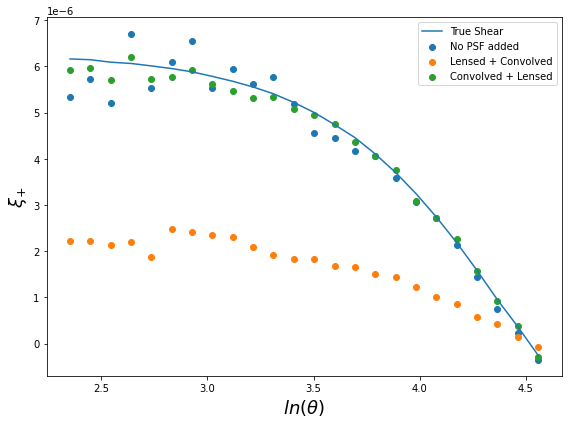

In [4]:
fig = plot_comparison(10_000_000)
fig.savefig('psf-and-shear.png', dpi=200)